In [1]:
%matplotlib inline

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
#data libraries
import pandas as pd
import numpy as np

# iris dataset
from sklearn import datasets

# keras libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

# import tensorflow
import tensorflow as tf

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#mathematical libraries
from scipy.stats import pearsonr

#notebook options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

Using TensorFlow backend.


# IRIS dataset analysis using Deep Learning.

## Purpose of the analysis: 

Inspired by [__Jason Brownlee__](https://machinelearningmastery.com/) blog and books I've decided to start developing my __Deep Learning__ knowldege. 

This is the second  Keras project to further train foundamental Depp Learning skills, so I will start with initial analysis and next will evaluate __Keras Model__ and try to tune it a little bit to get a better result. 

## Table of contents:
1. Exploratory analysis
2. DL


## 1. Exploratory analysis

In [3]:
df = pd.read_csv(r".\data\iris.csv", sep=',', names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"])
df.sample(3)

,sepal_length,sepal_width,petal_length,petal_width,class
100,6.3,3.3,6.0,2.5,Iris-virginica
141,6.9,3.1,5.1,2.3,Iris-virginica
84,5.4,3.0,4.5,1.5,Iris-versicolor


In [4]:
print(F"Number of instances: {df.shape[0]}, number of attributes: {df.shape[1]}.")

Number of instances: 150, number of attributes: 5.


We can see that there are 150 rows and 5 data columns. The last 5th column is our target variable __class__.

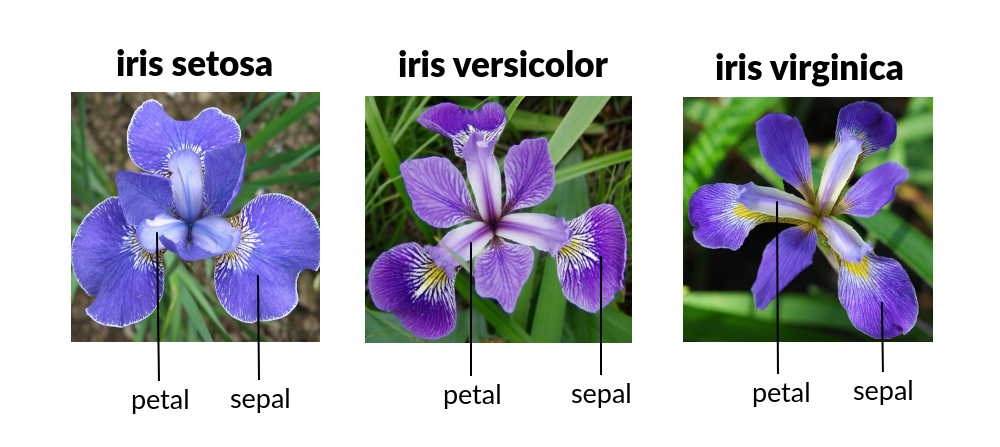

In [5]:
Image(filename=r".\data\img\iris-species.png", width = 450)

In [6]:
df["class"].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

And it has 3 different values: __Iris-virginica__, __Iris-setosa__ and __Iris-versicolor__, all of them equally distributed.

Next lets search for variable types, missing values and statistics. Data information:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
class           150 non-null object
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


We do not have any missing values so after statistical distibution will go to visual analysis.

In [8]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Boxplot distribution:

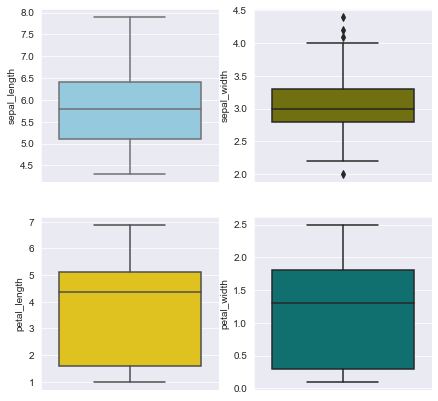

In [9]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.boxplot(df["sepal_length"] , color="skyblue", ax=axes[0, 0], orient="v")
sns.boxplot(df["sepal_width"] , color="olive", ax=axes[0, 1], orient="v")
sns.boxplot(df["petal_length"] , color="gold", ax=axes[1, 0], orient="v")
sns.boxplot(df["petal_width"] , color="teal", ax=axes[1, 1], orient="v")
plt.show()

Quite similar __sepal__ distributions with few outliers in __sepal_lenght__. __Petal__ variables distributions really similar. 

Distplots:

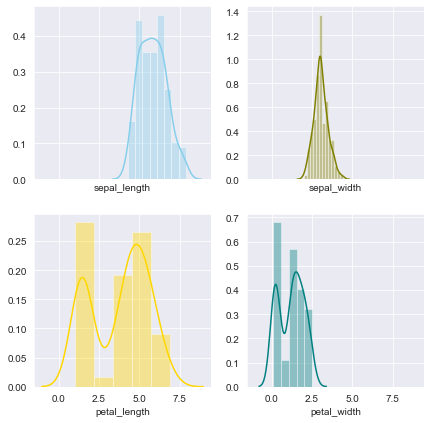

In [10]:
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.distplot( df["sepal_length"] , color="skyblue", ax=axes[0, 0])
sns.distplot( df["sepal_width"] , color="olive", ax=axes[0, 1])
sns.distplot( df["petal_length"] , color="gold", ax=axes[1, 0])
sns.distplot( df["petal_width"] , color="teal", ax=axes[1, 1])
plt.show()

Pairplot:

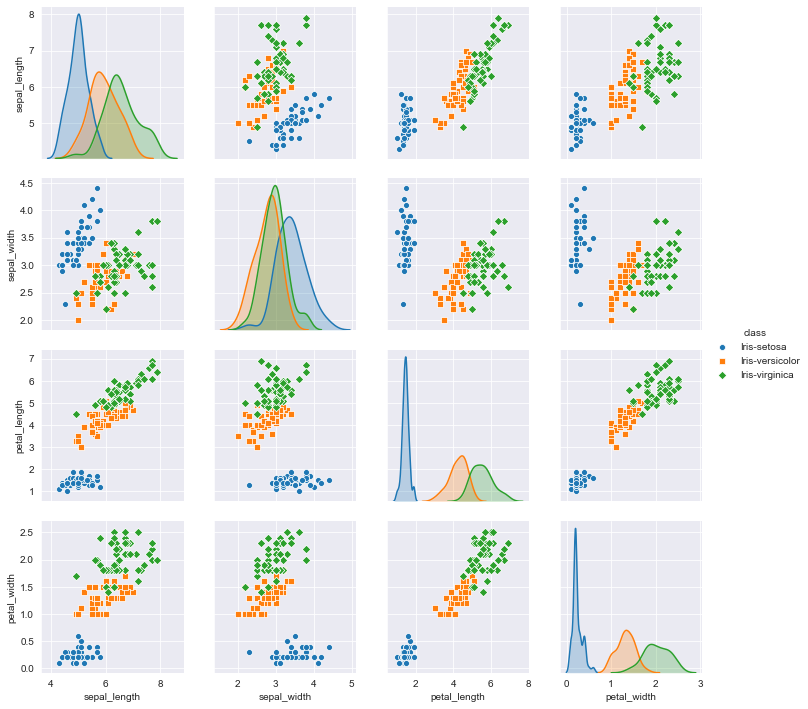

In [11]:
fig = sns.pairplot(df, hue="class", markers=["o", "s", "D"])
plt.show()

We will make it little bit more clear to see:

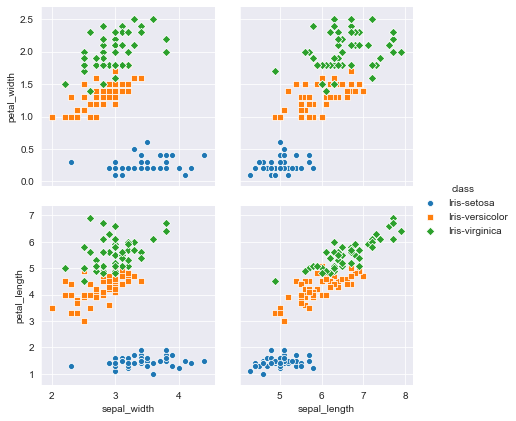

In [12]:
sns.pairplot(df, x_vars=["sepal_width", "sepal_length"], y_vars=["petal_width", "petal_length"], hue="class", markers=["o", "s", "D"],
            height=3, aspect=1)
plt.show()

Looking at the pairplots the correlation between variables seems straightforward.

Last plot will be the heatmap:

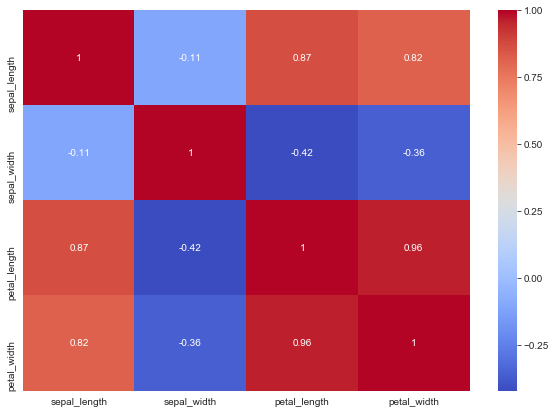

In [13]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True, cmap='coolwarm')
plt.show()

From heatmap explaration we can addition see stron corellation between petal_length and sepal_length, and petal_width to sepal_length. But the stronesgt one: petal_width to petal_length has 0.96 score, which is almost perfect corellation coefficient.

Let's look once more on this features.

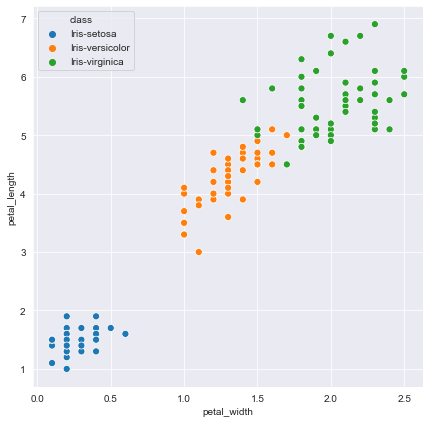

In [14]:
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(x="petal_width", y="petal_length", data=df, hue="class", s=50, markers=["o", "s", "D"])
plt.show()

Joint plot to better see data distribution:

<Figure size 504x504 with 0 Axes>

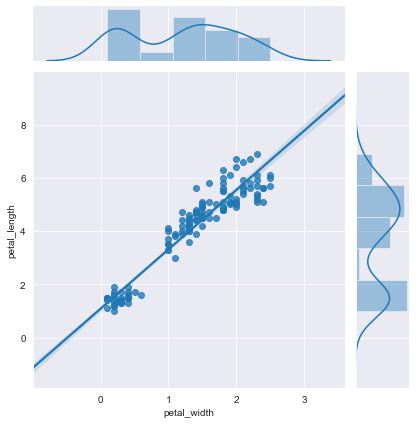

In [15]:
plt.figure(figsize=(7, 7))
sns.jointplot(x="petal_width", y="petal_length", data=df, kind="reg")
plt.show()

And with lmplot. Means parameter can be used to divide the graph into discrete interval. For this we can use the parameter x_estimator and pass in its value as np.mean:

<Figure size 504x504 with 0 Axes>

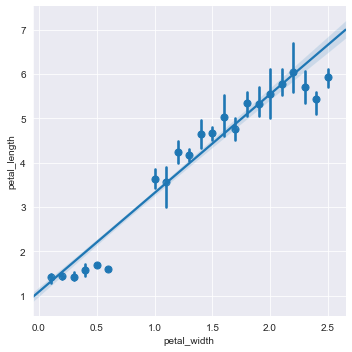

In [16]:
plt.figure(figsize=(7, 7))
ax = sns.lmplot(x="petal_width", y="petal_length", data=df, x_estimator=np.mean)
plt.show()

##  2. Keras algorithm

#### 2.1. Baseline model evaluation

First we have to transform our __class__ labels to numerical values:

In [17]:
# split into input (X) and output (Y) variables
X = df.iloc[:,0:4].astype(float)
Y = df.iloc[:,4]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [18]:
print(f"Dummy_y variable example: {dummy_y[0]}")

Dummy_y variable example: [1. 0. 0.]


Next we will create our model architecure:

4 INPUTS -> [12 HIDDEN NODES] -> [8 HIDDEN NODES] -> [6 HIDDEN NODES] -> 3 OUTPUTS

In [19]:
def dl_model():
    # Create model
    model = Sequential()
    model.add(Dense(12, input_dim=4, activation="relu"))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Last step is to evaluate our model:

In [20]:
estimator = KerasClassifier(build_fn=dl_model, epochs=150, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print(f"Model accuracy: {(results.mean()*100):.4} with standard dev. {(results.std()*100):.4}")

Model accuracy: 96.67 with standard dev. 5.375


Pretty nice score,  we will finish with this! :)